## Build the Model

The model features the most drastic changes.

### Different RNN Architecture

We'll be using a different RNN architecture called a Long Short-Term Memory (LSTM). Why is an LSTM better than a standard RNN? Standard RNNs suffer from the [vanishing gradient problem](https://en.wikipedia.org/wiki/Vanishing_gradient_problem). LSTMs overcome this by having an extra recurrent state called a _cell_, $c$ - which can be thought of as the "memory" of the LSTM - and the use use multiple _gates_ which control the flow of information into and out of the memory. For more information, go [here](https://colah.github.io/posts/2015-08-Understanding-LSTMs/). We can simply think of the LSTM as a function of $x_t$, $h_t$ and $c_t$, instead of just $x_t$ and $h_t$.

$$(h_t, c_t) = \text{LSTM}(x_t, h_t, c_t)$$

Thus, the model using an LSTM looks something like (with the embedding layers omitted):

![](https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/assets/sentiment2.png?raw=1)

The initial cell state, $c_0$, like the initial hidden state is initialized to a tensor of all zeros. The sentiment prediction is still, however, only made using the final hidden state, not the final cell state, i.e. $\hat{y}=f(h_T)$.

### Bidirectional RNN

The concept behind a bidirectional RNN is simple. As well as having an RNN processing the words in the sentence from the first to the last (a forward RNN), we have a second RNN processing the words in the sentence from the **last to the first** (a backward RNN). At time step $t$, the forward RNN is processing word $x_t$, and the backward RNN is processing word $x_{T-t+1}$. 

In PyTorch, the hidden state (and cell state) tensors returned by the forward and backward RNNs are stacked on top of each other in a single tensor. 

We make our sentiment prediction using a concatenation of the last hidden state from the forward RNN (obtained from final word of the sentence), $h_T^\rightarrow$, and the last hidden state from the backward RNN (obtained from the first word of the sentence), $h_T^\leftarrow$, i.e. $\hat{y}=f(h_T^\rightarrow, h_T^\leftarrow)$   

The image below shows a bi-directional RNN, with the forward RNN in orange, the backward RNN in green and the linear layer in silver.  

![](https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/assets/sentiment3.png?raw=1)

### Multi-layer RNN

Multi-layer RNNs (also called *deep RNNs*) are another simple concept. The idea is that we add additional RNNs on top of the initial standard RNN, where each RNN added is another *layer*. The hidden state output by the first (bottom) RNN at time-step $t$ will be the input to the RNN above it at time step $t$. The prediction is then made from the final hidden state of the final (highest) layer.

The image below shows a multi-layer unidirectional RNN, where the layer number is given as a superscript. Also note that each layer needs their own initial hidden state, $h_0^L$.

![](https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/assets/sentiment4.png?raw=1)

### Regularization

Although we've added improvements to our model, each one adds additional parameters. Without going into overfitting into too much detail, the more parameters you have in in your model, the higher the probability that your model will overfit (memorize the training data, causing  a low training error but high validation/testing error, i.e. poor generalization to new, unseen examples). To combat this, we use regularization. More specifically, we use a method of regularization called *dropout*. Dropout works by randomly *dropping out* (setting to 0) neurons in a layer during a forward pass. The probability that each neuron is dropped out is set by a hyperparameter and each neuron with dropout applied is considered indepenently. One theory about why dropout works is that a model with parameters dropped out can be seen as a "weaker" (less parameters) model. The predictions from all these "weaker" models (one for each forward pass) get averaged together withinin the parameters of the model. Thus, your one model can be thought of as an ensemble of weaker models, none of which are over-parameterized and thus should not overfit.

### Implementation Details

Another addition to this model is that we are not going to learn the embedding for the `<pad>` token. This is because we want to explitictly tell our model that padding tokens are irrelevant to determining the sentiment of a sentence. This means the embedding for the pad token will remain at what it is initialized to (we initialize it to all zeros later). We do this by passing the index of our pad token as the `padding_idx` argument to the `nn.Embedding` layer.

To use an LSTM instead of the standard RNN, we use `nn.LSTM` instead of `nn.RNN`. Also, note that the LSTM returns the `output` and a tuple of the final `hidden` state and the final `cell` state, whereas the standard RNN only returned the `output` and final `hidden` state. 

As the final hidden state of our LSTM has both a forward and a backward component, which will be concatenated together, the size of the input to the `nn.Linear` layer is twice that of the hidden dimension size.

Implementing bidirectionality and adding additional layers are done by passing values for the `num_layers` and `bidirectional` arguments for the RNN/LSTM. 

Dropout is implemented by initializing an `nn.Dropout` layer (the argument is the probability of dropping out each neuron) and using it within the `forward` method after each layer we want to apply dropout to. **Note**: never use dropout on the input or output layers (`text` or `fc` in this case), you only ever want to use dropout on intermediate layers. The LSTM has a `dropout` argument which adds dropout on the connections between hidden states in one layer to hidden states in the next layer. 

As we are passing the lengths of our sentences to be able to use packed padded sequences, we have to add a second argument, `text_lengths`, to `forward`. 

Before we pass our embeddings to the RNN, we need to pack them, which we do with `nn.utils.rnn.packed_padded_sequence`. This will cause our RNN to only process the non-padded elements of our sequence. The RNN will then return `packed_output` (a packed sequence) as well as the `hidden` and `cell` states (both of which are tensors). Without packed padded sequences, `hidden` and `cell` are tensors from the last element in the sequence, which will most probably be a pad token, however when using packed padded sequences they are both from the last non-padded element in the sequence. Note that the `lengths` argument of `packed_padded_sequence` must be a CPU tensor so we explicitly make it one by using `.to('cpu')`.

We then unpack the output sequence, with `nn.utils.rnn.pad_packed_sequence`, to transform it from a packed sequence to a tensor. The elements of `output` from padding tokens will be zero tensors (tensors where every element is zero). Usually, we only have to unpack output if we are going to use it later on in the model. Although we aren't in this case, we still unpack the sequence just to show how it is done.

The final hidden state, `hidden`, has a shape of _**[num layers * num directions, batch size, hid dim]**_. These are ordered: **[forward_layer_0, backward_layer_0, forward_layer_1, backward_layer 1, ..., forward_layer_n, backward_layer n]**. As we want the final (top) layer forward and backward hidden states, we get the top two hidden layers from the first dimension, `hidden[-2,:,:]` and `hidden[-1,:,:]`, and concatenate them together before passing them to the linear layer (after applying dropout). 

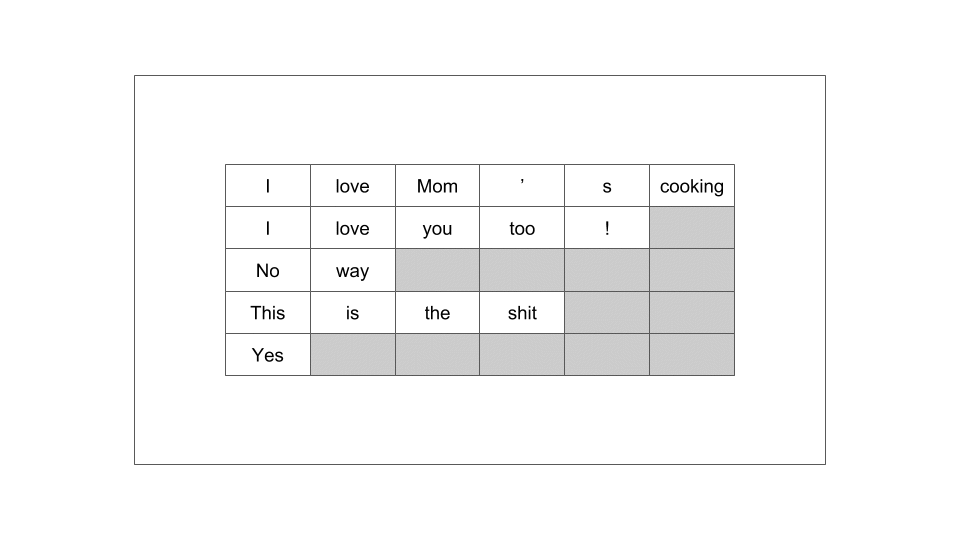

In [2]:
!pip install portalocker
import portalocker

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Access to the raw dataset iterators

The torchtext library provides a few raw dataset iterators, which yield the raw text strings. For example, the AG_NEWS dataset iterators yield the raw data as a tuple of label and text.

To access torchtext datasets, please install torchdata following instructions at https://github.com/pytorch/data.



In [3]:
from torchtext.datasets import IMDB
import torchtext
import torch 
SEED = 1234

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torchtext.__version__

'0.15.1+cpu'

https://www.scaler.com/topics/pytorch/map-style-vs-itetrable-datasets/

# Map-style Dataset

A map-style dataset is the one that implements the __getitem__() and __len__() protocols and can be represented as a map from (possibly non-integral) indices or keys to the data samples.

For example, when accessed with dataset[index], such a dataset could read the index-th element and its corresponding label from the data source, which could be a folder located on the disk.

The torch.utils.data.Dataset class is the base class providing support for Map-style datasets.

The len method simply returns the length of the dataset. While it is not strictly an abstract method, it is recommended that every subclass of the Dataset class implements this. The reason why that is so is that this method is expected to return the size of the dataset by many implementations of the class torch.utils.data.Sampler and the default options of the classtorch.utils.data.DataLoader.

__getitem__ is an abstract method in the abstract Dataset class and hence any subclass of torch.utils.data.The dataset class should implement this method.

This is a dunder method and deals with returning the input features and the corresponding label of a particular data point at a specified index.

In [4]:

from torch.utils.data import Dataset

class MapDataset(Dataset):

    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data['sentence'][index]






# Iterable Style Dataset

Iterable style datasets are primarily useful when the data arrives as part of a stream and when each data point cannot be mapped into an index.

An iterable-style dataset can be created as an instance of a subclass of the class IterableDataset that implements the __iter__() protocol and represents an iterable over the data samples. This dataset type is particularly suitable for cases where random data reads are costly or even improbable and where the batch size depends on the fetched data rather than being pre-defined/configurable using a dataloader.

For example, when called iter on like iter(dataset), such a dataset would return a stream of data reading from a database, from website calls over a network or a remote server, or even from logs generated in real-time.

Unlike map-style datasets where the data loading order can be specified via the dataloader, the data loading order for iterable-style datasets is entirely controlled by the user-defined iterable. This also means that iterable size datasets easily allow for dynamic batch sizes as iter protocol makes it possible to yield a batch of data at a time rather than a single data point.

torch.utils.data.IterableDataset class is the PyTorch primitive concerned with supporting iterable style datasets.

In [5]:
from torch.utils.data import IterableDataset
import math

# custom iterable dataset class
class MyIterableDataset(IterableDataset):
    def __init__(self, start, end):
        super(MyIterableDataset).__init__()
        self.start = start
        self.end = end

    def __iter__(self):
        worker_info = torch.utils.data.get_worker_info() # when called in a worker process, returns information about the worker
        # Single-process data loading
        if worker_info is None:
            iter_start = self.start
            iter_end = self.end

        # multi-process data loading
        else:
            per_worker = int(math.ceil((self.end - self.start) / float(worker_info.num_workers)))
            worker_id = worker_info.id

            # iter_start and iter_end are now different for each worker. This avoids duplication of data across worker processes
            iter_start = self.start + worker_id * per_worker
            iter_end = min(iter_start + per_worker, self.end)

        # return an iterable
        return iter(range(iter_start, iter_end))

# Map-style vs Iterable Datasets

Until now, we learned about map style datasets and iterable style datasets individually while understanding how each works mechanically.


However, making a brief yet clear distinction between the two is crucial to enhance understanding. Therefore, we lay below some points of difference that conceptually differentiate map-style datasets from iterable-style datasets.


Map style datasets are useful when reading the data randomly through subsequent calls like dataset[idx] is viable, and the length of the full dataset is known beforehand. In contrast, iterable style datasets are used in cases when the data comes sequentially from a stream, and the full length of how large the dataset is could be unknown.


With map-style datasets, a single item could be loaded at a time, like so:


for the index in the sampler:
    sample = dataset[index]


On the other hand, with iterable style datasets, it is possible to load a batch (or a single item too) of data at a time, like so :


for batch in iter(dataset):  # batch/sample depending on the implementation
    body


The data loading order for map-style datasets is controlled by the dataloader class using another Sampler class. Hence, the DataLoader samples indices of the items to be loaded (this is also where the len method implemented in custom dataset classes is used). On the other hand, the data loading order in iterable style datasets is completely determined by the user implementation, and the dataloader has nothing to do with it.


In the case of map-style datasets, the DataLoader specifies a fixed batch size and takes care of collation (possibly with user-defined custom collate_fn). In contrast, with iterable style datasets, batching could be implemented in the iter protocol itself.


We must be careful with multiprocessing when dealing with iterable style datasets as specified above (by using worker info). However, with map-style datasets, the dataloader internally applies to shard in every dataset copy across the different worker processes.

In [6]:
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset

train_iter,test_iter = IMDB()
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)
num_train = int(len(train_dataset) * 0.95)
train_dataset, valid_dataset = random_split(train_dataset, [num_train, len(train_dataset) - num_train])



In [7]:
train_dataset[0]

(2,
 'Along with "King of the Rocket Men", this was still being repeated on BBC TV in the early to mid eighties. If I was loading up a time capsule of this period both these series would definitely go in.<br /><br />Someone watching it for the first time will think it is silly but this is one of the best examples of the "Serials". Don Del Oro will make you laugh (When I was little my nickname for him was Mr Dustbin head) and it was funny upon being shot at he says "Your bullets can\'t harm me" then he stumbles back, seemingly less than happy. I also like the way he dispenses with Sebastian in the first episode.<br /><br />I watched this again because I had good memories of it from years back, there are some good stunts and good music, it has the ingredients you expect including water,rockfalls,runaway carts... Apart from the first episode(with Ralph Faulkner)the swordplay wasn\'t nearly as good as I remembered it, and yes it features the inevitable "flashback" episode! It gets 8 out of

# Prepare data processing pipelines

We have revisited the very basic components of the torchtext library, including vocab, word vectors, tokenizer. Those are the basic data processing building blocks for raw text string.

Here is an example for typical NLP data processing with tokenizer and vocabulary. The first step is to build a vocabulary with the raw training dataset. Here we use built in factory function build_vocab_from_iterator which accepts iterator that yield list or iterator of tokens. Users can also pass any special symbols to be added to the vocabulary.

Next, we have to build a _vocabulary_. This is a effectively a look up table where every unique word in your data set has a corresponding _index_ (an integer).

We do this as our machine learning model cannot operate on strings, only numbers. Each _index_ is used to construct a _one-hot_ vector for each word. A one-hot vector is a vector where all of the elements are 0, except one, which is 1, and dimensionality is the total number of unique words in your vocabulary, commonly denoted by $V$.

![](https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/assets/sentiment5.png?raw=1)

The number of unique words in our training set is over 100,000, which means that our one-hot vectors will have over 100,000 dimensions! This will make training slow and possibly won't fit onto your GPU (if you're using one). 

There are two ways effectively cut down our vocabulary, we can either only take the top $n$ most common words or ignore words that appear less than $m$ times. We'll do the former, only keeping the top 25,000 words.

What do we do with words that appear in examples but we have cut from the vocabulary? We replace them with a special _unknown_ or `<unk>` token. For example, if the sentence was "This film is great and I love it" but the word "love" was not in the vocabulary, it would become "This film is great and I `<unk>` it".

The following builds the vocabulary, only keeping the most common `max_size` tokens.

Why is the vocab size 25002 and not 25000? One of the addition tokens is the `<unk>` token and the other is a `<pad>` token.

When we feed sentences into our model, we feed a _batch_ of them at a time, i.e. more than one at a time, and all sentences in the batch need to be the same size. Thus, to ensure each sentence in the batch is the same size, any shorter than the longest within the batch are padded.

![](https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/assets/sentiment6.png?raw=1)

We can also view the most common words in the vocabulary and their frequencies.

In [8]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer('basic_english')

def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)



In [10]:
#Pretrained WordEmbedding
from torchtext.vocab import vocab


def vocab_with_pretrained_vector(TRAIN_ITER, DIM):
  vec = torchtext.vocab.GloVe(name='6B', dim=DIM)
  _voc = vocab(vec.stoi)
  voc = build_vocab_from_iterator(yield_tokens(train_iter), 
                                    specials=["<unk>", "<pad>"],
                                    max_tokens= 25000)
  voc.set_default_index(voc["<unk>"])
  embedding = vec.get_vecs_by_tokens(list(voc.get_itos()), lower_case_backup = True)
  print(embedding.size())
  return embedding, voc

In [11]:
pretrained_embedding, voc = vocab_with_pretrained_vector(train_iter, 100)

.vector_cache/glove.6B.zip: 862MB [02:40, 5.38MB/s]                           
100%|█████████▉| 399999/400000 [00:17<00:00, 22640.86it/s]


torch.Size([25000, 100])


In [12]:
text_pipeline = lambda x: voc(tokenizer(x))
label_pipeline = lambda x: int(x) - 1

In [13]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from torch import nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Generate data batch and iterator

torch.utils.data.DataLoader is recommended for PyTorch users (a tutorial is here). It works with a map-style dataset that implements the getitem() and len() protocols, and represents a map from indices/keys to data samples. It also works with an iterable dataset with the shuffle argument of False.

Before sending to the model, collate_fn function works on a batch of samples generated from DataLoader. The input to collate_fn is a batch of data with the batch size in DataLoader, and collate_fn processes them according to the data processing pipelines declared previously. Pay attention here and make sure that collate_fn is declared as a top level def. This ensures that the function is available in each worker.

In this example, the text entries in the original data batch input are packed into a list and concatenated as a single tensor for the input of nn.EmbeddingBag. The offset is a tensor of delimiters to represent the beginning index of the individual sequence in the text tensor. Label is a tensor saving the labels of individual text entries.

In [40]:
#collate_function: process the list of samples to form a batch. 
# https://androidkt.com/create-dataloader-with-collate_fn-for-variable-length-input-in-pytorch/

def custom_collate_fn(batch):
    label_list, text_list,text_len = [], [], []
    for (_label, _text) in batch:
         label_list.append(label_pipeline(_label))
         processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
         text_list.append(processed_text)
         text_len.append(len(processed_text))
         
    label_list = torch.tensor(label_list, dtype=torch.int64).unsqueeze(dim=1)
    text_list = pad_sequence(text_list, padding_value = 1)
    return label_list.to(device), text_list.to(device), text_len

In [41]:
train_dataloader = DataLoader(train_dataset, batch_size=16,
                              shuffle=True, collate_fn=custom_collate_fn)

valid_dataloader = DataLoader(valid_dataset, batch_size=16,
                              shuffle=True, collate_fn=custom_collate_fn)

test_dataloader = DataLoader(test_dataset, batch_size=16,
                              shuffle=True, collate_fn=custom_collate_fn)

## Build the Model

The next stage is building the model that we'll eventually train and evaluate. 

There is a small amount of boilerplate code when creating models in PyTorch, note how our `RNN` class is a sub-class of `nn.Module` and the use of `super`.

Within the `__init__` we define the _layers_ of the module. Our three layers are an _embedding_ layer, our RNN, and a _linear_ layer. All layers have their parameters initialized to random values, unless explicitly specified.

The embedding layer is used to transform our sparse one-hot vector (sparse as most of the elements are 0) into a dense embedding vector (dense as the dimensionality is a lot smaller and all the elements are real numbers). This embedding layer is simply a single fully connected layer. As well as reducing the dimensionality of the input to the RNN, there is the theory that words which have similar impact on the sentiment of the review are mapped close together in this dense vector space. For more information about word embeddings, see [here](https://monkeylearn.com/blog/word-embeddings-transform-text-numbers/).

The RNN layer is our RNN which takes in our dense vector and the previous hidden state $h_{t-1}$, which it uses to calculate the next hidden state, $h_t$.

![](https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/assets/sentiment7.png?raw=1)

Finally, the linear layer takes the final hidden state and feeds it through a fully connected layer, $f(h_T)$, transforming it to the correct output dimension.

The `forward` method is called when we feed examples into our model.

Each batch, `text`, is a tensor of size _**[sentence length, batch size]**_. That is a batch of sentences, each having each word converted into a one-hot vector. 

You may notice that this tensor should have another dimension due to the one-hot vectors, however PyTorch conveniently stores a one-hot vector as it's index value, i.e. the tensor representing a sentence is just a tensor of the indexes for each token in that sentence. The act of converting a list of tokens into a list of indexes is commonly called *numericalizing*.

The input batch is then passed through the embedding layer to get `embedded`, which gives us a dense vector representation of our sentences. `embedded` is a tensor of size _**[sentence length, batch size, embedding dim]**_.

`embedded` is then fed into the RNN. In some frameworks you must feed the initial hidden state, $h_0$, into the RNN, however in PyTorch, if no initial hidden state is passed as an argument it defaults to a tensor of all zeros.

The RNN returns 2 tensors, `output` of size _**[sentence length, batch size, hidden dim]**_ and `hidden` of size _**[1, batch size, hidden dim]**_. `output` is the concatenation of the hidden state from every time step, whereas `hidden` is simply the final hidden state. We verify this using the `assert` statement. Note the `squeeze` method, which is used to remove a dimension of size 1. 

Finally, we feed the last hidden state, `hidden`, through the linear layer, `fc`, to produce a prediction.

In [131]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding.from_pretrained(pretrained_embedding, padding_idx = pad_idx)
        
        self.rnn = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout)
        
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_len):
        
        #text = [sent len, batch size]

        embedded = self.dropout(self.embedding(text))

        #embedded = [sent len, batch size, emb dim]
        
        #pack sequence
        # lengths need to be on CPU!
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths = text_len, enforce_sorted = False)


        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        
        #unpack sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

        #output = [sent len, batch size, hid dim * num directions]
        #output over padding tokens are zero tensors
        
        #hidden = [num layers * num directions, batch size, hid dim]
        #cell = [num layers * num directions, batch size, hid dim]
        
        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        #and apply dropout
        
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
                
        #hidden = [batch size, hid dim * num directions]
            
        return self.fc(hidden)

In [132]:
INPUT_DIM = len(pretrained_embedding)
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = voc['<pad>']

model = RNN(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT, 
            PAD_IDX)

In [133]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 2,310,657 trainable parameters


In [134]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()
model = model.to(device)
criterion = criterion.to(device)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)

In [135]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

The `train` function iterates over all examples, one batch at a time. 

`model.train()` is used to put the model in "training mode", which turns on _dropout_ and _batch normalization_. Although we aren't using them in this model, it's good practice to include it.

For each batch, we first zero the gradients. Each parameter in a model has a `grad` attribute which stores the gradient calculated by the `criterion`. PyTorch does not automatically remove (or "zero") the gradients calculated from the last gradient calculation, so they must be manually zeroed.

We then feed the batch of sentences, `text`, into the model. Note, you do not need to do `model.forward(text)`, simply calling the model works. The `squeeze` is needed as the predictions are initially size _**[batch size, 1]**_, and we need to remove the dimension of size 1 as PyTorch expects the predictions input to our criterion function to be of size _**[batch size]**_.

The loss and accuracy are then calculated using our predictions and the labels, `label`, with the loss being averaged over all examples in the batch.

We calculate the gradient of each parameter with `loss.backward()`, and then update the parameters using the gradients and optimizer algorithm with `optimizer.step()`.

The loss and accuracy is accumulated across the epoch, the `.item()` method is used to extract a scalar from a tensor which only contains a single value.

In [136]:
import time


def train(dataloader):
    model.train()
    epoch_loss, epoch_acc = 0, 0
    log_interval = len(dataloader)
    start_time = time.time()

    for idx, (label, text, text_len) in enumerate(dataloader):
        optimizer.zero_grad()
        predicted_label = model(text, text_len)
        loss = criterion(predicted_label, label.float())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        epoch_acc += binary_accuracy(predicted_label,label).item()
        epoch_loss += loss.item()
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches '
                  '| accuracy {:8.3f}'.format(epoch, idx, len(dataloader),
                                            epoch_loss/len(dataloader)))
            #total_acc, total_count = 0, 0
            start_time = time.time()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)



`evaluate` is similar to `train`, with a few modifications as you don't want to update the parameters when evaluating.

`model.eval()` puts the model in "evaluation mode", this turns off _dropout_ and _batch normalization_. Again, we are not using them in this model, but it is good practice to include them.

No gradients are calculated on PyTorch operations inside the `with no_grad()` block. This causes less memory to be used and speeds up computation.

The rest of the function is the same as `train`, with the removal of `optimizer.zero_grad()`, `loss.backward()` and `optimizer.step()`, as we do not update the model's parameters when evaluating.

In [137]:
def evaluate(dataloader):
    model.eval()
    epoch_loss, epoch_acc = 0, 0
    with torch.no_grad():
        for idx, (label, text, text_len) in enumerate(dataloader):
            predicted_label = model(text, text_len)
            loss = criterion(predicted_label, label.float())
            epoch_acc += binary_accuracy(predicted_label,label).item()
            epoch_loss += loss.item()

    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

In [138]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
EPOCHS = 5

best_valid_loss = float('inf')
for epoch in range(EPOCHS):
    epoch_start_time = time.time()
    start_time = time.time()

    train_loss, train_acc = train(train_dataloader)
    valid_loss, valid_acc = evaluate(valid_dataloader)
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut2-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')